# Tarea 1. M√©todos de Descenso para Funciones de Base Radial (RBFs)

**Enya Tovar Estrada**

Fecha de entrega: 01 Marzo 2024


**Instrucciones**

Resolver el problema de ajuste de RBFs:

‚Ä¢ Usar una imagen momocrom√°tica (tonos de gris) de 256x256 pixeles.

‚Ä¢ Usar entre 100 a 500 funciones radiales. Encuentre el compromiso que
le parezca adecuado entre buena reconstrucci√≥n y rapidez en la reconstrucci√≥n, esto es a su criterio.

‚Ä¢ Los centros Œ∏ de las funciones radiales se inicializan aleatoriamente en el intervalo [1,N]

‚Ä¢ Busque un valor de Œ∫ adecuado para la imagen de prueba que seleccione.

‚Ä¢ Ajustar el modelo usando la multiqu√°drica y compara con la la Gaussiana

‚Ä¢ Usar los m√©todos de descenso de gradiente: GD, Nesterov y Adam. Puede, si le parece conveniente, implementar la versi√≥n estoc√°stica.

‚Ä¢ Incluir una penalizaci√≥n (regularizaci√≥n) en las Œ±¬¥s: Esto es a√±adir a la funci√≥n objetivo el t√©rmino Œª‚à•Œ±‚à•^2 , donde Œª es un par√°metro que controla cuantas Œ± se expresan.


**Librer√≠as.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
import urllib.request

**Cargar imagen y ajustar.**

In [3]:
#Descarga de la imagen
Archivo="Imagen.png"
urllib.request.urlretrieve("https://images.wikidexcdn.net/mwuploads/esssbwiki/7/74/latest/20230328205524/Shy_Guy_%28Mario_Party_Superstars%29.png", Archivo)
D_Imagen = Archivo
Imagen = cv2.imread(D_Imagen, cv2.IMREAD_GRAYSCALE)

Dimensiones originales de la imagen: 
 Altura=955 y Ancho=853


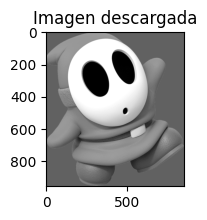

In [4]:
#Revisamos algunas caracter√≠sticas de la imgen y la imprimimos c:
altura, ancho = Imagen.shape[:2]
print(f"Dimensiones originales de la imagen: \n Altura={altura} y Ancho={ancho}")
plt.figure(figsize=(6, 2))
plt.imshow(Imagen,cmap='gray')
plt.title('Imagen descargada')
plt.show()

In [5]:
#Para trabajar hay que hacerle un re-size
#Voy a trabajar con pocas dimensiones para que no tome tanto tiempo compilar
#De igual forma la imagen es muy grande por lo que puedo hacer el resize que se pide de 256 x 256 despu√©s
dimension = 30
Imagen_redim = cv2.resize(Imagen, (dimension,dimension))
#Normalizamos
Imagen_norm = Imagen_redim/255

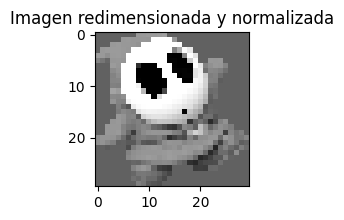

In [6]:
#Volvemos a imprimir ya la imagen normalizada
plt.figure(figsize=(6, 2))
plt.imshow(Imagen_norm, cmap='gray')
plt.title('Imagen redimensionada y normalizada')
plt.show()

**Gaussiana y Multiqu√°drica.**

In [7]:
#Tenemos que ajustar el modelo usando la multiquadrica y comparar con la Gaussiana.
#Gaussiana
def gaussiana(r,k):
  return np.exp(-k*(r**2))
#Multiqu√°drica
def multiquadratica(r,k):
  return np.sqrt((r**2) + k)

In [8]:
#Gaussiana
def derivada_gaussiana(alpha, x, theta, k):
    #Norma entre theta y x
    norma = np.linalg.norm(theta - x)
    #Derivada de la funci√≥n gaussiana
    derivada = np.ones(2)
    derivada[0] = (x[0] - theta[0])
    derivada[1] = (x[1] - theta[1])

    z = -2 * alpha * k * np.exp(-k * norma**2) * derivada
    return z

#Multiqu√°drica
def derivada_multiquadratica(alpha, x, theta, k):
    norma = np.linalg.norm(theta - x)
    #Derivada de la funci√≥n multiquadrica
    derivada = np.ones(2)
    derivada[0] = (x[0] - theta[0])
    derivada[1] = (x[1] - theta[1])

    #Calcula la derivada de la funci√≥n radial multiquadrica
    return alpha * (-2 * norma) / np.sqrt(norma**2 + k) * derivada

**Matriz_phi.**

In [9]:
def calcular_matriz_phi(puntos_datos, centros, funcion_radial, k):
    #Inicializamos la matriz con ceros
    Matriz_phi = np.zeros((len(puntos_datos), len(centros)))

    #Iteramos sobre los puntos de datos
    for i in range(len(puntos_datos)):
        #Iteramos sobre los centros de los clusteres
        for j in range(len(centros)):
            #Calculamos la distancia entre el punto de datos y el centro del cl√∫ster
            r = np.linalg.norm(puntos_datos[i] - centros[j])
            #Calculamos el valor de la funci√≥n radial para la distancia r
            Matriz_phi[i,j] = funcion_radial(r,k)

    return Matriz_phi

**Coeficientes alpha.**

In [10]:
#Coeficientes alpha para el modelo.
def calcular_alpha(objetivo, x, N, funcion_radial, theta, kappa, alpha_reg=0.1):
    # Generar la matriz phi
    matriz_phi = calcular_matriz_phi(x, theta, funcion_radial, kappa)

    # Calcular los coeficientes alpha utilizando regularizaci√≥n de Tikhonov
    matriz_regularizada = matriz_phi.T @ matriz_phi + alpha_reg * np.identity(N)
    coeficientes_alpha = np.linalg.solve(matriz_regularizada, matriz_phi.T @ objetivo)

    return coeficientes_alpha

**Gradiente Matriz_phi.**

In [11]:
def calcular_gradiente_phi(x, alpha, theta, objetivo, funcion_radial, funcion_derivada, k):
    M_phi = calcular_matriz_phi(x, theta, funcion_radial, k)
    M = M_phi @ alpha
    gradiente = np.zeros(theta.shape)

    for i in range(len(theta)):
        for j in range(len(x)):
            z = (objetivo[j] - M[j]) * funcion_derivada(alpha[i], x[j], theta[i], k)
            #Actualizamos el gradiente
            gradiente[i] = gradiente[i] + z

    return gradiente

**Funci√≥n Objetivo.**

In [12]:
def funcion_objetivo(Matriz_phi, objetivo, alpha, lambda_):
    #Realizamos la predicci√≥n multiplicando la matriz phi por los coeficientes alpha del modelo
    predicciones = Matriz_phi @ alpha
    #Calculamos el error cuadr√°tico
    error_cuadratico_medio = np.sum((objetivo - predicciones)**2) / 2
    #Calculamos el t√©rmino de regularizaci√≥n para penalizar
    termino_regularizacion = lambda_ *np.sum(alpha**2)
    #Valor de la funci√≥n objetivo combinando el error cuadr√°tico y el t√©rmino de regularizaci√≥n
    valor_funcion_objetivo = error_cuadratico_medio + termino_regularizacion

    return valor_funcion_objetivo

**M√©todos de descenso de gradiente.**

**GD**

In [13]:
#Descenso gradiente
def GD(theta_inicial, maxIter, tasa_aprendizaje, calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, k):
    # Inicializamos los par√°metros theta con los valores iniciales
    theta = theta_inicial
    # Iteramos hasta alcanzar el n√∫mero m√°ximo de iteraciones
    for i in range(maxIter):
        #Calculamos el gradiente de la funci√≥n de costo
        gradiente = calcular_gradiente_phi(x, alpha, theta, objetivo, funcion_radial, funcion_derivada, k)
        #Actualizamos los par√°metros theta utilizando el gradiente y la tasa de aprendizaje
        theta = theta - tasa_aprendizaje * gradiente

    #Devolvemos los par√°metros optimizados
    return theta

**Nesterov**

In [14]:
def Nesterov(theta_inicial, maxIter, a, b, calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, k):
    theta = theta_inicial
    p = np.zeros(theta.shape)

    for i in range(maxIter):
        pre_theta = theta - 2.0*a*p
        g = calcular_gradiente_phi(x, alpha, pre_theta, objetivo, funcion_radial, funcion_derivada, k)
        #Actualizamos el momento
        p = g + b*p
        #Actualizamos theta
        theta = pre_theta - a*p

    #Par√°metros optimizados c:
    return theta

**ADAM**

In [15]:
def ADAM(theta_inicial, tasa_aprendizaje, beta1, beta2, epsilon, maxIter, calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, k):
    theta = theta_inicial
    cont = 0
    p1 = np.zeros(theta.shape)
    p2 = np.zeros(theta.shape)

    for i in range(maxIter):
        for j in range(len(theta)):
            cont += 1
            gradiente = calcular_gradiente_phi(x, alpha, theta, objetivo, funcion_radial, funcion_derivada, k)
            #Actualizamos los momentos p1 y p2
            p1 = beta1 * p1 + (1-beta1) * gradiente
            p2 = beta2 * p2 + (1-beta2) * (gradiente**2)
            #Corregimos los momentos sesgados
            p1_hat = p1 / (1- beta1**cont)
            p2_hat = p2 / (1- beta2**cont)
            #Actualizamos theta utilizando los momentos corregidos
            theta -= tasa_aprendizaje * p1_hat / (np.sqrt(p2_hat) + epsilon)

    return theta

**Reconstrucci√≥n de la imagen.**

In [16]:
# Vamos a reconstruir la imagen a partir de la matriz de caracter√≠sticas y los coeficientes alpha c:
def Reconstruccion_Imagen(longitud_x, longitud_y, alpha, x, theta, funcion_radial, kappa):
    phi = calcular_matriz_phi(x, theta, funcion_radial, kappa)
    reconstruida = phi @ alpha
    reconstruida = reconstruida.reshape(longitud_x, longitud_y)

    return reconstruida

**Procedimiento general.**

In [17]:
def Procesamiento(imagen, theta_inicial, iteraciones, tolerancia, J, funcion_radial, funcion_derivada, kappa, metodo, parametros):
    #Obtener las dimensiones de la imagen
    alto, ancho = imagen.shape
    theta1 = theta_inicial
    theta2 = np.random.uniform(1, alto + 1, size=(J, 2))
    #Generar las coordenadas x
    x = np.array([(i, j) for i in range(alto) for j in range(ancho)])
    #Aplanar la imagen
    objetivo = imagen.flatten()

    for i in range(iteraciones):
        #Calcular los coeficientes alpha
        alpha = calcular_alpha(objetivo, x, J, funcion_radial, theta1, kappa,alpha_reg=0.1)
        #Optimizaci√≥n seg√∫n el m√©todo seleccionado...
        if metodo == 1:
            theta2 = GD(theta1, parametros[0], parametros[1], calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, kappa)
        elif metodo == 2:
            theta2 = Nesterov(theta1, parametros[0], parametros[1], parametros[2], calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, kappa)
        elif metodo == 3:
            theta2 = ADAM(theta1, parametros[0], parametros[1], parametros[2], parametros[3], parametros[4], calcular_gradiente_phi, x, alpha, objetivo, funcion_radial, funcion_derivada, kappa)
        #Actualizar theta1 con los nuevos valores calculados
        theta1 = theta2

    #Reconstruir la imagen utilizando los par√°metros optimizados
    imagen_reconstruida = Reconstruccion_Imagen(alto, ancho, alpha, x, theta2, funcion_radial, kappa)
    # Devolver la imagen reconstruida
    return imagen_reconstruida

# PROCESO CON FUNCI√ìN DE BASE RADIAL GAUSSIANA

In [26]:
#Condiciones para los procesos
#Pregunt√© con los compa√±eros y me dijeron que el Kappa pod√≠as hacerlo al tanteo
#El profesor les dijo 1/(2*5**2) , o eso le funcion√≥ a alguien de imagen 50x50
#Yo usar√© 1/(2*3**2) porque mi imagen es m√°s peque√±a
Kappa = 1/(2*(3**2))
N=100 #Es la cota m√≠nima porque no quiero que tarde mucho
theta1 = np.random.uniform(1,Imagen_norm.shape[0]+1, size=(N,2))

**Gauss-GD**

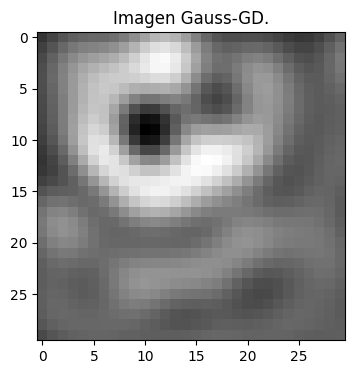

In [19]:
ParametrosF = [10, 1E-4]
ImagenFinalGaussGD = Procesamiento(Imagen_norm, theta1, 3, 1E-6, N, gaussiana, derivada_gaussiana, Kappa, 1, ParametrosF)
# Mostrar las im√°genes
plt.figure(figsize=(8,4))
plt.imshow(ImagenFinalGaussGD, cmap='gray')
plt.title('Imagen Gauss-GD.')
plt.show()

**Gauss-Nesterov**

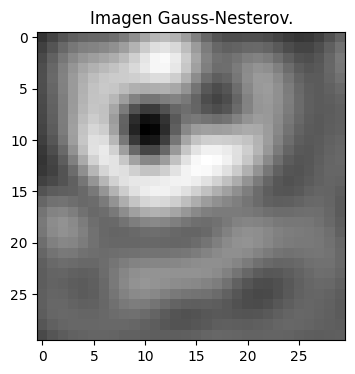

In [20]:
ParametrosN = [2, 1e-5, 1e-5]
ImagenFinalGaussNesterov = Procesamiento(Imagen_norm, theta1, 3, 1e-6, N, gaussiana, derivada_gaussiana, Kappa, 2, ParametrosN)
plt.figure(figsize=(8, 4))
plt.imshow(ImagenFinalGaussNesterov, cmap='gray')
plt.title('Imagen Gauss-Nesterov.')
plt.show()

**Gauss_ADAM**

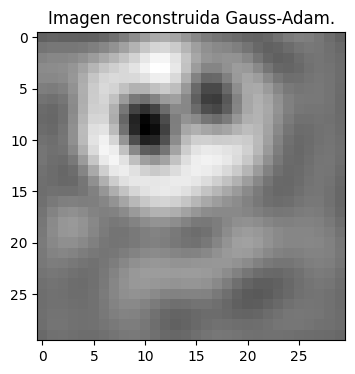

In [25]:
ParametrosA = [0.01, 0.9, 0.999, 1E-4, 5]
ImagenFinalGaussADAM = Procesamiento(Imagen_norm, theta1, 3, 1E-4, N, gaussiana, derivada_gaussiana, Kappa, 3, ParametrosA)
plt.figure(figsize=(8,4))
plt.imshow(ImagenFinalGaussADAM, cmap='gray')
plt.title('Imagen reconstruida Gauss-Adam.')
plt.show()

#PROCESO CON FUNCI√ìN DE BASE RADIAL MULTICUADR√ÅTICA

In [22]:
#Vuelvo a definir no porque sea necesario, solo es por orden
Kappa = 1/(2*(3**2))
N=100
theta1 = np.random.uniform(1,Imagen_norm.shape[0]+1, size=(N,2))

Multicuadr√°tica-GD

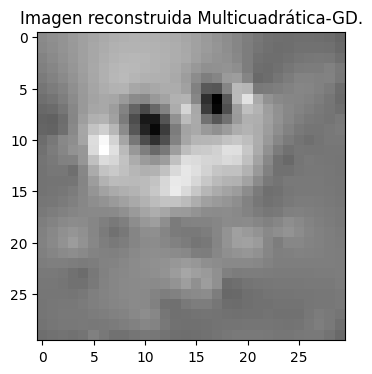

In [23]:
ParametrosF = [10, 1E-6]
ImagenFinalMulticuadraticaGD = Procesamiento(Imagen_norm, theta1, 3, 1E-6, N, multiquadratica, derivada_multiquadratica, Kappa, 1, ParametrosF)
# Mostrar las im√°genes
plt.figure(figsize=(8, 4))
plt.imshow(ImagenFinalMulticuadraticaGD, cmap='gray')
plt.title('Imagen reconstruida Multicuadr√°tica-GD.')
plt.show()

**Multicuadr√°tica-Nesterov**

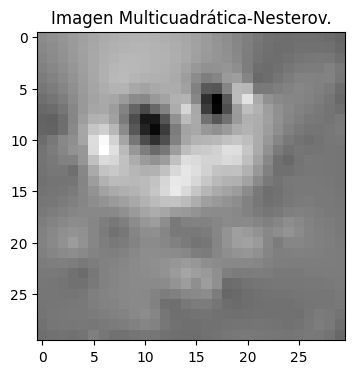

In [24]:
ParametrosN = [2, 1E-5, 1E-5]
ImagenFinalMulticuadraticaNesterov = Procesamiento(Imagen_norm, theta1, 3, 1E-6, N, multiquadratica, derivada_multiquadratica, Kappa, 2, ParametrosN)
plt.figure(figsize=(8,4))
plt.imshow(ImagenFinalMulticuadraticaNesterov, cmap='gray')
plt.title('Imagen Multicuadr√°tica-Nesterov.')
plt.show()

**Multicuadr√°tica-ADAM**

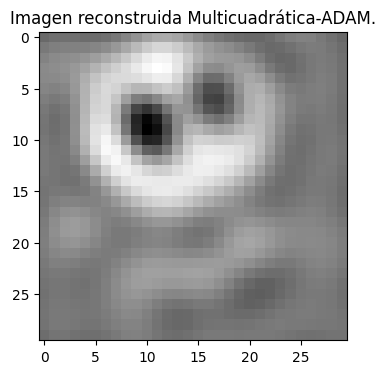

In [27]:
ParametrosA = [0.01, 0.9, 0.999, 1E-4, 5]
ImagenFinalMulticuadraticaADAM = Procesamiento(Imagen_norm, theta1, 3, 1E-6, N, gaussiana, derivada_gaussiana, Kappa, 3, ParametrosA)
plt.figure(figsize=(8,4))
plt.imshow(ImagenFinalMulticuadraticaADAM, cmap='gray')
plt.title('Imagen reconstruida Multicuadr√°tica-ADAM.')
plt.show()

# RESULTADOS FINALES

**Vamos a comparar todas las reconstrucciones.**

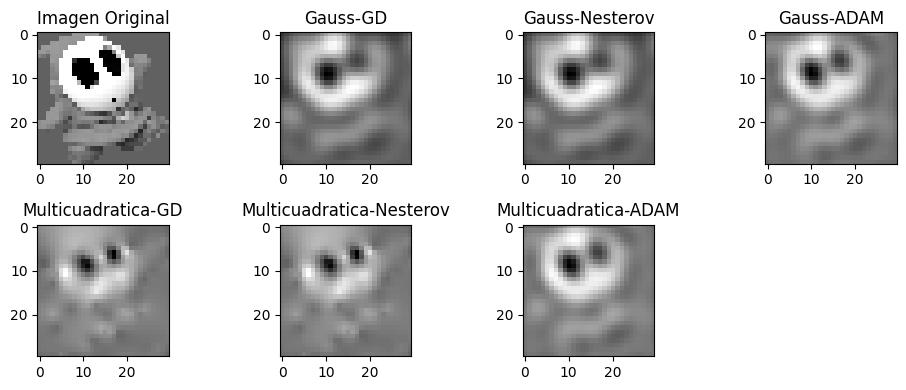

In [29]:
import matplotlib.pyplot as plt
imagenes = [Imagen_norm, ImagenFinalGaussGD, ImagenFinalGaussNesterov, ImagenFinalGaussADAM, ImagenFinalMulticuadraticaGD, ImagenFinalMulticuadraticaNesterov, ImagenFinalMulticuadraticaADAM]
T = ["Imagen Original", "Gauss-GD", "Gauss-Nesterov", "Gauss-ADAM", "Multicuadratica-GD", "Multicuadratica-Nesterov", "Multicuadratica-ADAM"]
plt.figure(figsize=(10,4))
for i in range(len(imagenes)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(imagenes[i], cmap='gray')
    plt.title(T[i])
plt.tight_layout()
plt.show()

Con las imagenes nos podemos dar cuenta que al emplear ADAM tuvimos una mejor reconstrucci√≥n de la imagen en ambas funciones radiales. Sin embargo, para poder establecer esto con mayor seguridad vamos a calcular un tipo de error, el **MSE**.

Vamos a calcular la diferencia cuadr√°tica promedio entre los valores de p√≠xeles originales y los valores de p√≠xeles reconstruidos.

OJO entonces que un MSE bajo indica una reconstrucci√≥n mejor

In [30]:
def MSE(imagen_original,imagen_reconstruida):
    mse = np.mean((imagen_original - imagen_reconstruida) ** 2)
    return mse

mse_resultados = []
#Recorremos todas las imagenes, el arreglo est√° definido en la celda de arriba
for i in range(1, len(imagenes)):
    mse = MSE(imagenes[0], imagenes[i])
    mse_resultados.append(mse)

for i in range(1, len(mse_resultados) + 1):
    print(f"MSE {T[i]}:", mse_resultados[i - 1])

MSE Gauss-GD: 0.025494315758520795
MSE Gauss-Nesterov: 0.025496741661001368
MSE Gauss-ADAM: 0.019738361643338875
MSE Multicuadratica-GD: 0.023279293022108523
MSE Multicuadratica-Nesterov: 0.023298643326608682
MSE Multicuadratica-ADAM: 0.01919002817314176


Efectivamente podemos confirmar que los valores m√°s peque√±os (es decir las combinaciones que tuvieron mejor desempe√±o) fueron aquellas con **ADAM** y especificamente aquella que emple√≥ **funci√≥n radial multicuadratica**. üòÉ